In [1]:
import qutip
import tensornetwork as tn
from tensornetwork.visualization.graphviz import to_graphviz 
import qutip_tensornetwork as qtn
import numpy as np
from qutip_tensornetwork import data
from qutip_tensornetwork.quantum import QuOperator
%load_ext autoreload
%autoreload 2

/home/kaladin/Documents/git/qutip/qutip5/qutip/__init__.py:105: UserWarning: matplotlib not found: Graphics will not work.
  warnings.warn("matplotlib not found: Graphics will not work.")


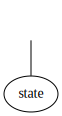

In [3]:
# Create random ket for 24 qubits as a network.
n = 20
random_state = qutip.rand_ket(N=2**n, dims=[[2]*n, [1]*n]).to('network')

# We will name it just because we can
nodes = random_state.data.nodes
nodes.pop().name = "state"
random_state.data

In [3]:
2**n*128/1024/1024/1024 #GB

2.0

In [4]:
2**n*2**n*128/1024**3 # No way we represent this dense operator

33554432.0

In [5]:
# The dimension at this moment of the network is 2**n instead of [2]*n
# That is because we obtained the data transforming it from a dense 
# representation.
random_state.data.out_edges[0].dimension

16777216

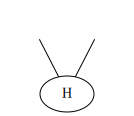

In [6]:
h_single = qutip.operations.hadamard_transform().to('network')
h_single.data.nodes.pop().name = "H"
h_single.data

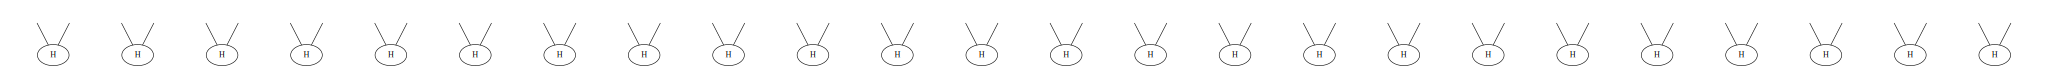

In [7]:
# Tensor operation already included
h_tensor = qutip.tensor([h_single]*n)
to_graphviz(h_tensor.data.nodes, engine='dot')

In [8]:
# H does have the dimension of [2]*n as it was explicitly tensored
h_tensor.data.dims

[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]

In [9]:
# The two objecst have different dimensions (as networks) but they can 
# still be operated. This is because we reshape the object with compact
# dimension (random_state in this case) to the one with explicit dimension
# assuming that higher level abstractions will keep track of the correct dimension
# at each time, ensuring the operation is valid. 
# This has the disadvantage of having two independent dims:
# the tensor-netowork dims
# and the qobj dims. Not something I like but I guess is the sacrifice 
# we need to make to properly operate with dense without including dims 
# to dense.
result = h_tensor@random_state

In [11]:
%%timeit
# For 13 qubits I notice that it takes 50% more time than for the sparse 
# method I discuss in my blog. That is due to the overhead and Im guessing
# it gets more favourable for the tensor-network approach the more operations
# are included and the larger the system (less memory that needs to move
# around).
result =  h_tensor*random_state
result.data.to_array()

3.97 s ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
4*25*1000/60/60 # Approximate time to simulate, in hours, one circuit of depth 25 with 1000 "monte-calor shots". 

27.77777777777778

In [17]:
result.data.to_array()

array([[ 1.05608490e-04-1.44681463e-04j],
       [ 1.30986691e-05-1.87511286e-05j],
       [ 1.62799226e-04+3.13173410e-04j],
       ...,
       [-9.07152349e-06-1.79802676e-04j],
       [ 7.68563323e-05-1.06788679e-04j],
       [-5.75649846e-05-7.48195563e-06j]])

In [64]:
# With dense it just breaks. We can not represent the operator.
random_state = random_state.to('dense')
h_tensor = h_tensor.to('dense')

ValueError: The network includes unexpected dangling edges (that are not members of ignore_edges).